Loading real data...
Processing Waveforms and Extracting Features...
Total extracted breaths: 2220
Running AI Anomaly Detection...
Clustering Complete! Generating 3D Plot...
3D Plotting Saved Successfully!


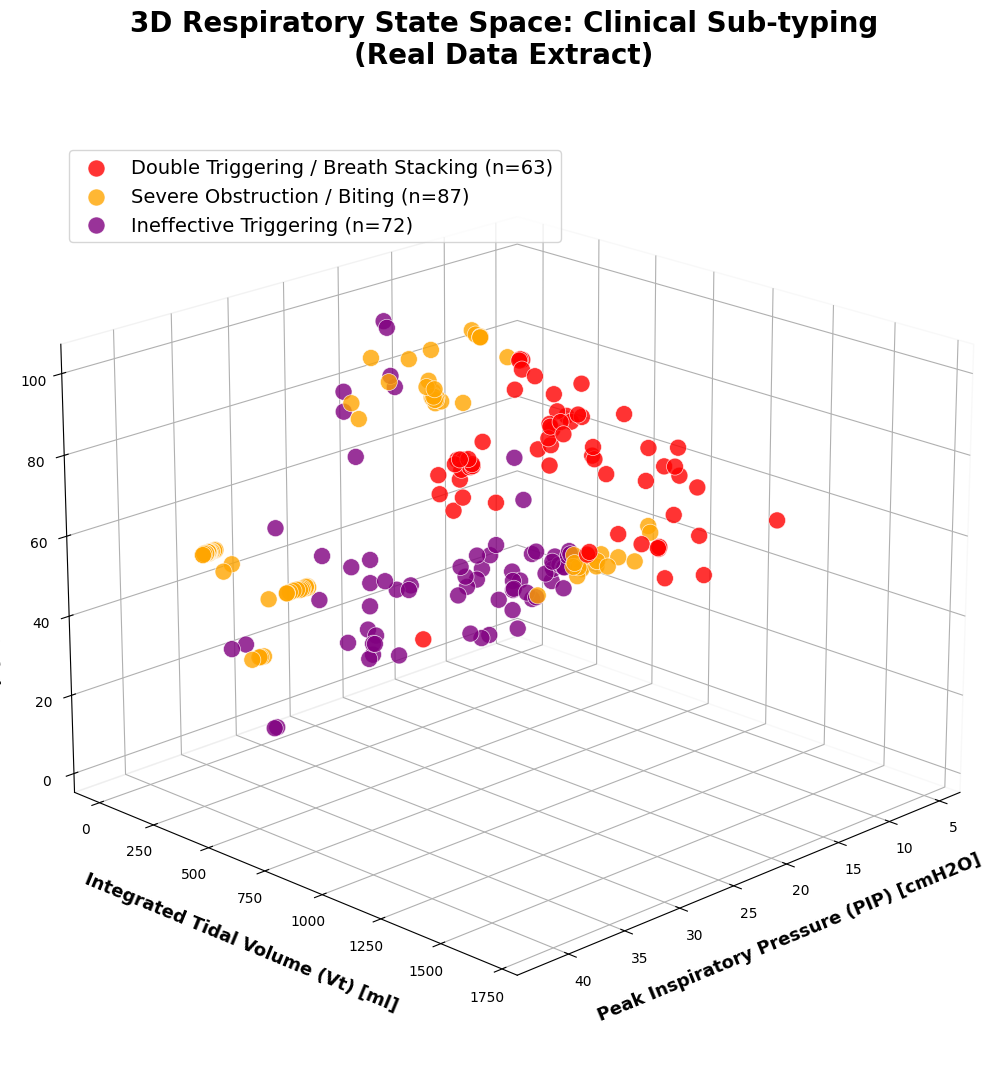

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

print("Loading real data...")
df = pd.read_csv('mv_waveform_2026-02-05.csv').dropna(subset=['RAW_WAVEFORM'])

def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            vals.append((int(h, 16) - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0)
        except:
            vals.append(0)
    return np.array(vals)

def segment_breaths(pressure_sig, flow_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > 2.0:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'pip': np.max(pressure_sig[idx_start:idx_end]),
                'max_flow': np.max(flow_sig[idx_start:idx_end]),
                'flow': flow_sig[idx_start:idx_end]
            })
    return breaths

all_breaths = []
time_step = 0.04

print("Processing Waveforms and Extracting Features...")
for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex = "", ""
    for b in blocks:
        p_hex += b[0:30]; f_hex += b[30:60]
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, time_axis)
    for b in breaths:
        insp_flow = b['flow'][b['flow'] > 0]
        calc_vt = np.sum(insp_flow) / 60 * time_step * 1000
        all_breaths.append({
            'PIP': b['pip'],
            'Max_Flow': b['max_flow'],
            'Calculated_Vt_ml': calc_vt
        })

df_feat = pd.DataFrame(all_breaths)
print(f"Total extracted breaths: {len(df_feat)}")

# 2. Isolation Forest (Anomaly Detection)
print("Running AI Anomaly Detection...")
iso = IsolationForest(contamination=0.1, random_state=42)
df_feat['Anomaly_Status'] = iso.fit_predict(df_feat[['PIP', 'Max_Flow', 'Calculated_Vt_ml']])

# 3. K-Means Sub-typing บนกลุ่ม Anomaly
anomalies_df = df_feat[df_feat['Anomaly_Status'] == -1].copy().reset_index(drop=True)
kmeans = KMeans(n_clusters=3, random_state=42)
anomalies_df['Cluster'] = kmeans.fit_predict(anomalies_df[['PIP', 'Max_Flow', 'Calculated_Vt_ml']])

def assign_labels(df, cluster_col):
    means = df.groupby(cluster_col)[['PIP', 'Calculated_Vt_ml']].mean()
    dt_cluster = means['Calculated_Vt_ml'].idxmax()
    so_cluster = means.drop(dt_cluster)['PIP'].idxmax()
    it_cluster = means.drop([dt_cluster, so_cluster]).index[0]
    
    label_map = {
        dt_cluster: 'Double Triggering / Breath Stacking',
        so_cluster: 'Severe Obstruction / Biting',
        it_cluster: 'Ineffective Triggering'
    }
    return df[cluster_col].map(label_map)

anomalies_df['Label'] = assign_labels(anomalies_df, 'Cluster')
print("Clustering Complete! Generating 3D Plot...")

# --- สร้างกราฟ 3D Scatter Plot ---
fig = plt.figure(figsize=(14, 11))
ax = fig.add_subplot(111, projection='3d')

color_map = {
    'Double Triggering / Breath Stacking': 'red',
    'Severe Obstruction / Biting': 'orange',
    'Ineffective Triggering': 'purple'
}

for label, color in color_map.items():
    subset = anomalies_df[anomalies_df['Label'] == label]
    ax.scatter(subset['PIP'], subset['Calculated_Vt_ml'], subset['Max_Flow'], 
               c=color, s=150, alpha=0.8, edgecolors='white', linewidth=0.5, label=f"{label} (n={len(subset)})")

# ตกแต่งกราฟ 3D
ax.set_title('3D Respiratory State Space: Clinical Sub-typing\n(Real Data Extract)', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Peak Inspiratory Pressure (PIP) [cmH2O]', fontsize=13, labelpad=12, fontweight='bold')
ax.set_ylabel('Integrated Tidal Volume (Vt) [ml]', fontsize=13, labelpad=15, fontweight='bold')
ax.set_zlabel('Maximum Flow (L/min)', fontsize=13, labelpad=12, fontweight='bold')

# ปรับมุมมองให้อ่านง่าย
ax.view_init(elev=20, azim=45) 
ax.legend(fontsize=14, loc='upper left', bbox_to_anchor=(0.05, 0.95))

# ปรับให้แกนใสๆ เพื่อให้ดู Modern
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

plt.tight_layout()
plt.savefig('real_data_3d_respiratory_space.png', dpi=150)
print("3D Plotting Saved Successfully!")

Multi-Angle 3D Plot Saved!
Generating Rotating GIF Animation...
Rotating GIF Saved as 'rotating_3d_space.gif'!


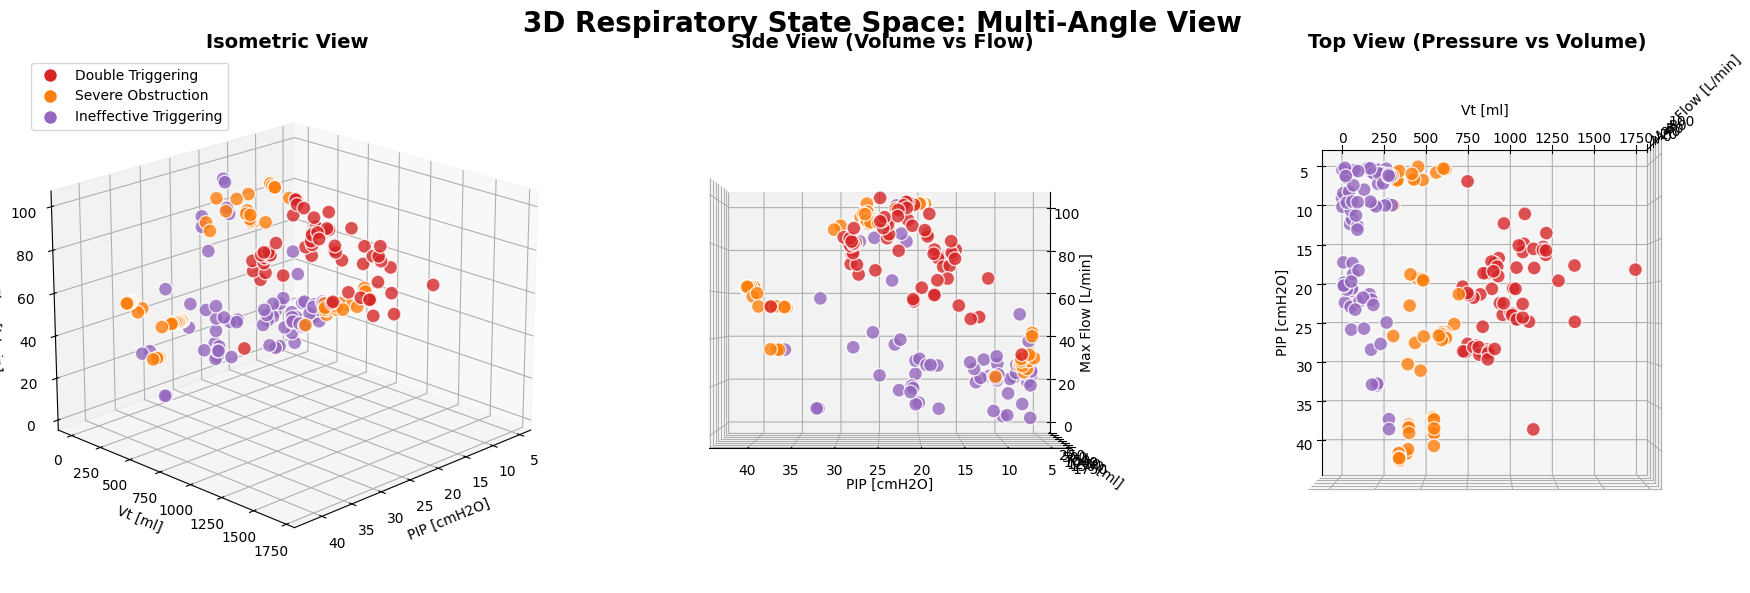

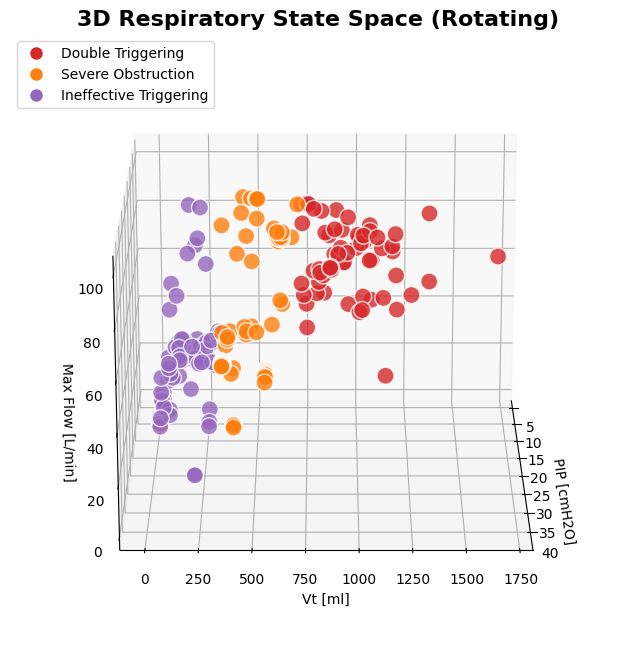

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
import warnings
import matplotlib.animation as animation
warnings.filterwarnings('ignore')

# 1. โหลดข้อมูล (ใช้ 150 แถวเพื่อให้ประมวลผลเร็ว)
df = pd.read_csv('mv_waveform_2026-02-05.csv').dropna(subset=['RAW_WAVEFORM'])

def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            vals.append((int(h, 16) - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0)
        except:
            vals.append(0)
    return np.array(vals)

def segment_breaths(pressure_sig, flow_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > 2.0:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'pip': np.max(pressure_sig[idx_start:idx_end]),
                'max_flow': np.max(flow_sig[idx_start:idx_end]),
                'flow': flow_sig[idx_start:idx_end]
            })
    return breaths

all_breaths = []
time_step = 0.04

for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex = "", ""
    for b in blocks:
        p_hex += b[0:30]; f_hex += b[30:60]
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, time_axis)
    for b in breaths:
        insp_flow = b['flow'][b['flow'] > 0]
        calc_vt = np.sum(insp_flow) / 60 * time_step * 1000
        all_breaths.append({
            'PIP': b['pip'],
            'Max_Flow': b['max_flow'],
            'Calculated_Vt_ml': calc_vt
        })

df_feat = pd.DataFrame(all_breaths)

# 2. Isolation Forest (Anomaly Detection)
iso = IsolationForest(contamination=0.1, random_state=42)
df_feat['Anomaly_Status'] = iso.fit_predict(df_feat[['PIP', 'Max_Flow', 'Calculated_Vt_ml']])

# 3. K-Means Sub-typing บนกลุ่มที่ผิดปกติเท่านั้น (-1)
anomalies_df = df_feat[df_feat['Anomaly_Status'] == -1].copy().reset_index(drop=True)

kmeans = KMeans(n_clusters=3, random_state=42)
anomalies_df['Cluster'] = kmeans.fit_predict(anomalies_df[['PIP', 'Max_Flow', 'Calculated_Vt_ml']])

def assign_labels(df, cluster_col):
    means = df.groupby(cluster_col)[['PIP', 'Calculated_Vt_ml']].mean()
    dt_cluster = means['Calculated_Vt_ml'].idxmax()
    so_cluster = means.drop(dt_cluster)['PIP'].idxmax()
    it_cluster = means.drop([dt_cluster, so_cluster]).index[0]
    
    label_map = {
        dt_cluster: 'Double Triggering',
        so_cluster: 'Severe Obstruction',
        it_cluster: 'Ineffective Triggering'
    }
    return df[cluster_col].map(label_map)

anomalies_df['Clinical_Label'] = assign_labels(anomalies_df, 'Cluster')

# --- 4. สร้างภาพ Multi-Angle View ก่อน (เพื่อให้เห็นชัดๆ ว่าไม่ได้ซ้อนทับกันมั่ว) ---
fig = plt.figure(figsize=(18, 6))
fig.suptitle('3D Respiratory State Space: Multi-Angle View', fontsize=20, fontweight='bold', y=0.98)

color_map = {
    'Double Triggering': '#d62728', # แดง
    'Severe Obstruction': '#ff7f0e', # ส้ม
    'Ineffective Triggering': '#9467bd' # ม่วง
}

angles = [(20, 45, 'Isometric View'), (0, 90, 'Side View (Volume vs Flow)'), (90, 0, 'Top View (Pressure vs Volume)')]

for i, (elev, azim, title) in enumerate(angles):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    for label, color in color_map.items():
        subset = anomalies_df[anomalies_df['Clinical_Label'] == label]
        ax.scatter(subset['PIP'], subset['Calculated_Vt_ml'], subset['Max_Flow'], 
                   c=color, s=100, alpha=0.8, edgecolors='white', linewidth=1.0)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('PIP [cmH2O]', fontsize=10)
    ax.set_ylabel('Vt [ml]', fontsize=10)
    ax.set_zlabel('Max Flow [L/min]', fontsize=10)
    ax.view_init(elev=elev, azim=azim)

# Legend แค่กราฟแรก
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in color_map.items()]
fig.axes[0].legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.savefig('multi_angle_3d.png', dpi=150)
print("Multi-Angle 3D Plot Saved!")

# --- 5. สร้าง Rotating GIF สำหรับ Presentation ---
print("Generating Rotating GIF Animation...")
fig_anim = plt.figure(figsize=(10, 8))
ax_anim = fig_anim.add_subplot(111, projection='3d')
ax_anim.set_title('3D Respiratory State Space (Rotating)', fontsize=16, fontweight='bold')
ax_anim.set_xlabel('PIP [cmH2O]')
ax_anim.set_ylabel('Vt [ml]')
ax_anim.set_zlabel('Max Flow [L/min]')

for label, color in color_map.items():
    subset = anomalies_df[anomalies_df['Clinical_Label'] == label]
    ax_anim.scatter(subset['PIP'], subset['Calculated_Vt_ml'], subset['Max_Flow'], 
               c=color, s=150, alpha=0.8, edgecolors='white', linewidth=1.0)
ax_anim.legend(handles=legend_elements, loc='upper left')

def update(frame):
    ax_anim.view_init(elev=20, azim=frame)
    return ax_anim,

ani = animation.FuncAnimation(fig_anim, update, frames=np.arange(0, 360, 5), interval=100)
ani.save('rotating_3d_space.gif', writer='pillow', fps=10)
print("Rotating GIF Saved as 'rotating_3d_space.gif'!")